# 프로젝트: SentencePiece 사용하기

# 목차

Step 4. 네이버 영화리뷰 감정분석 문제에 SentencePiece 적용해 보기

만약 이 문제에서 tokenizer를 sentencepiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? 비교해 보는 것도 흥미로울 것입니다.

    네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

    학습된 모델로 sp_tokenize() 메소드 구현하기

    구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

    KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

    (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

    Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

    머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.


루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.
평가문항
	상세기준

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?
	코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?

2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?
	SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.

3. SentencePiece의 성능을 다각도로 비교분석하였는가?
	SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [2]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/aiffel_nlp_ex/data/naver/ratings.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 156878
Example:
>> 9428697	여자는 예쁜데 지루 지루	0
>> 487571	청소년을 두신 부모님은 자녀들과 함께 꼭 보세요.강추!	1
>> 10128218	의외로 반전영화임 처음엔 뭔지 모르다가	1
>> 2774743	쓰레기 더럽게 재미없다.	0
>> 5334930	6점대 후반 정도는 되는듯~ 지금 평점은 너무 높아~	0


문장의 최단 길이: 20
문장의 최장 길이: 74
문장의 평균 길이: 38


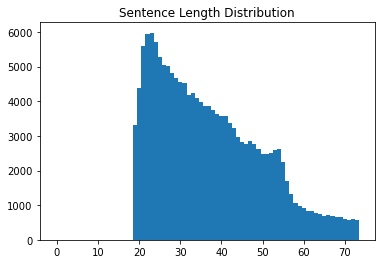

In [3]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

1) 길이 168 문장은 도대체 어떻게 생겨먹었지?

2) 앞에 치솟는 임의의 구간은 뭐지? 유의미한 데이터가 담겨있는 부분인가?

3) 어디서부터 어디까지 잘라서 쓰지?

In [4]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 168)

In [5]:
check_sentence_with_length(raw, 8)

In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 2000:
        print("Outlier Index:", idx+1)

Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56


In [7]:
check_sentence_with_length(raw, 40)

8577365	평점이 왜이렇게 낮은건지 모르겠어.. 정말 모르겠어..	1
2573152	내가 제일 좋아하는 영화ㅋㅋ이영화보고 드류 넘 좋아짐ㅋ	1
9687377	가구야는 이쁘고 스테마루는 잘생겼고 너무 너무 좋아요~	1
9721807	스텝업 시리즈중 최고다..댄스영화 통틀어서 최고이고..	1
5900727	눈물이나는몇안되는영화중하나...정말 많이 울었다....	1
9784680	이것도 영화라고,,늑대인간은 뭐여 엄마 귀신은 또 뭐여	0
2421373	제작이 430억이고 뭐고 간에 결말뭐냐?? 아나 OTL	0
8165557	괜찬은 영화라 생각하고 보면 오산입니다. 낚였다....	1
2223793	특수효과, 배우들, 연출 모두 부족한 저예산 B급물..	0
10153363	존라이더 북한에 투입시키면 1시간안에 김정은 목따올듯	0
2205993	거의 10년전에 봤던영화 다시찾느라 몇년 걸렸다 명작~	1
5118927	주인공이 너무 나약하네요..알포인트가 훨씬 수작입니다.	0
3558766	건담 시드의 전함 아크엔젤의 무기 트리스탄이랑 이졸데?	1
281489	찌질스러워 보이는 두 녀석 데려다가 뭐하자는 플레이인가?	0
7364676	억지 감동이 없어서 좋은 영화. 별 10개 주고 갑니다	1
3589793	미키.... 대체 왜 이런 영화에 출연한거야...ㅠㅠㅠ	0
8654968	왕십리 시사다녀왔어요 영화 좋네요~ 친구들에게 추천~!	1
7226888	어른들이 말하는 원작에 똥칠했다는 뜻이 이런 느낌이군요	0
8723117	오늘 조조로 봤는데... 영화보다 뛰쳐나갈번함...ㅡㅡ	0
8649061	이 영화를 보고나면 제라드 버틀러에게 반할수밖에 없는듯	1
6244011	서툴고 투박하지만 그래도 진심이 느껴지는 순수한 영화!	1
8205986	쓰레기같은 영화.. 동화 신데렐라가 훨씬 개연성 있어요	0
5071058	ㅋㅋㅋㅋㅋㅋㅋ 스카이라인으로 컨셉 바꿨구나 ㅋㅋㅋㅋㅋㅋ	0
9749816	평점 높네.. 솔직히 극장판 중에 제일재밋긴하지 제트가	1
3617301	여기 저기서 빌

Data Size: 156878
문장의 최단 길이: 20
문장의 최장 길이: 74
문장의 평균 길이: 38


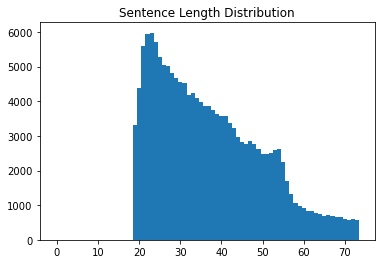

In [8]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

달라진게 없다....중복이 없다는 의미인가?

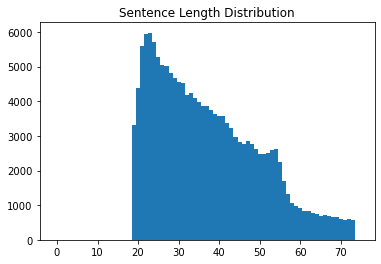

In [9]:
max_len = 75
min_len = 20

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

  중간에 솟아오른 부분은 제거 안해도 되나?

In [10]:
# sentence piece  모델 학습하기

import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/aiffel_nlp_ex/data/naver/ratings.txt'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_korean_spm*

-rw-r--r-- 1 aiffel-dj54 aiffel-dj54 368303  4월 19 14:41 naver_korean_spm.model
-rw-r--r-- 1 aiffel-dj54 aiffel-dj54 137692  4월 19 14:41 naver_korean_spm.vocab


In [11]:
# 모델 활용하기
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[2721, 14, 408, 22, 2446, 14, 149, 23, 6]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# Step 3. Tokenizer 함수 작성

In [12]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen = max_len)

    return tensor, word_index, index_word

In [13]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)
print(index_word)
print(word_index)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  523
  4504   21 2125 3028    6]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 2729 3237  250  589
    14  258 7939  813   12]]
{'<unk>': 0, '<s>': 1, '</s>': 2, '▁1': 3, '▁': 4, '▁0': 5, '.': 6, '▁9': 7, '..': 8, '이': 9, '▁8': 10, '▁영화': 11, '...': 12, '의': 13, '가': 14, '도': 15, '▁7': 16, '▁5': 17, '는': 18, '▁6': 19, ',': 20, '을': 21, '에': 22, '다':

In [14]:
my_corpus = ['쓰레기였다느느낌만 가득...보는관점은 자기나름이지만...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  107  634 1254 1725   36 4302   12  503  460
   600 2789 6401 1086   12]]


# 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

In [15]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf
train_data = pd.read_table('~/aiffel/aiffel_nlp_ex/data/naver/ratings_train.txt')
test_data = pd.read_table('~/aiffel/aiffel_nlp_ex/data/naver/ratings_test.txt')

train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [16]:
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [17]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [18]:
train_data.drop_duplicates(subset=['document'], inplace=True) 
train_data = train_data.dropna(how = 'any')

Data Size: 156878
문장의 최단 길이: 20
문장의 최장 길이: 74
문장의 평균 길이: 38


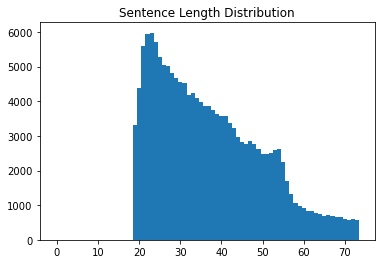

In [19]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

Data Size: 156878
문장의 최단 길이: 20
문장의 최장 길이: 74
문장의 평균 길이: 38


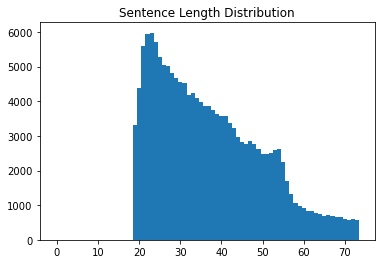

In [20]:
min_len = 75
max_len = 20
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [21]:
train_corpus = train_data['document']
train_tensor, word_index, index_word = sp_tokenize(s, train_corpus)

In [22]:
print(train_tensor)
# print(word_index)

[[   0    0    0 ... 2585   74 2524]
 [   0    0    0 ...   28  724  363]
 [   0    0    0 ... 2882 2745  307]
 ...
 [   0    0    0 ... 5010   85   31]
 [   0    0    0 ...  328  181  150]
 [   0    0    0 ...  435 6912   11]]


In [23]:
test_data.drop_duplicates(subset=['document'], inplace=True) 
test_data = test_data.dropna(how = 'any')

In [24]:
test_corpus = test_data['document']
test_tensor, word_index1, index_word1 = sp_tokenize(s, test_corpus)
print(test_tensor)
print(word_index1)
print(type(test_tensor))

[[   0    0    0 ...    0 3386  253]
 [   0    0    0 ... 3688 5565 3856]
 [   0    0    0 ...  234 3264 6276]
 ...
 [   0    0    0 ...  135  105 4278]
 [   0    0    0 ...  380  657   50]
 [   0    0    0 ...   18  228 4400]]
{0: '<unk>', 1: '<s>', 2: '</s>', 3: '▁1', 4: '▁', 5: '▁0', 6: '.', 7: '▁9', 8: '..', 9: '이', 10: '▁8', 11: '▁영화', 12: '...', 13: '의', 14: '가', 15: '도', 16: '▁7', 17: '▁5', 18: '는', 19: '▁6', 20: ',', 21: '을', 22: '에', 23: '다', 24: '▁3', 25: '▁4', 26: '▁10', 27: '은', 28: '지', 29: '▁2', 30: '고', 31: '?', 32: '!', 33: '한', 34: '▁너무', 35: '▁정말', 36: '만', 37: '를', 38: '▁이', 39: '로', 40: '영화', 41: '~', 42: '▁진짜', 43: '게', 44: '나', 45: '어', 46: '라', 47: '기', 48: '과', 49: '리', 50: '네', 51: '아', 52: '점', 53: '인', 54: '....', 55: '하고', 56: '▁안', 57: '!!', 58: '▁잘', 59: '으로', 60: '▁왜', 61: '▁아', 62: '요', 63: '해', 64: '서', 65: '▁그', 66: '자', 67: '에서', 68: '들', 69: '와', 70: '▁이런', 71: '▁더', 72: '스', 73: '▁다', 74: '네요', 75: '▁수', 76: '거', 77: '▁그냥', 78: '▁본', 79: '하는', 80: '

In [25]:
print(test_tensor)

[[   0    0    0 ...    0 3386  253]
 [   0    0    0 ... 3688 5565 3856]
 [   0    0    0 ...  234 3264 6276]
 ...
 [   0    0    0 ...  135  105 4278]
 [   0    0    0 ...  380  657   50]
 [   0    0    0 ...   18  228 4400]]


## 모델구성 및 validation set 구성

In [26]:
#RNN
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [27]:
print(test_tensor[1])
print(type(test_tensor[1]))
test_tensor.shape

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 5333 2120
 4162 2988 3391 3540 3712 3688 3562 3479 3479 4333 4162 2988 4910 2944
 3712 3688 5565 3856]
<class 'numpy.ndarray'>


(49157, 74)

## 데이터셋 분리

In [28]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [29]:
y_train = train_data.loc[:,'label']
y_train.head(10)

0    0
1    1
2    0
3    0
4    1
5    0
6    0
7    0
8    1
9    1
Name: label, dtype: int64

In [30]:
# X_train = train_data.loc[:,'document']
# X_train.head(10)

In [31]:
# validation set 29300건 분리
X_val = train_tensor[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = train_tensor[10000:]  
partial_y_train = y_train[10000:]

print(train_tensor.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(146182, 74)
(146182,)
(10000, 74)
(10000,)
(136182, 74)
(136182,)


# 모델훈련

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # 512, 100 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
266/266 [==============================] - 4s 8ms/step - loss: 0.6224 - accuracy: 0.6772 - val_loss: 0.3824 - val_accuracy: 0.8444
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3519 - accuracy: 0.8572 - val_loss: 0.3449 - val_accuracy: 0.8509
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3160 - accuracy: 0.8716 - val_loss: 0.3359 - val_accuracy: 0.8551
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3014 - accuracy: 0.8784 - val_loss: 0.3312 - val_accuracy: 0.8585
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2929 - accuracy: 0.8795 - val_loss: 0.3297 - val_accuracy: 0.8600
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2789 - accuracy: 0.8872 - val_loss: 0.3343 - val_accuracy: 0.8569
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2713 - accuracy: 0.8911 - val_loss: 0.3390 - val_accuracy: 0.8587
Epoch 

In [34]:
y_test = test_data.loc[:,'label']
y_test.head(10)

0    1
1    0
2    0
3    0
4    0
5    1
6    0
7    0
8    0
9    1
Name: label, dtype: int64

In [35]:
X_test = test_tensor   

In [36]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3764 - accuracy: 0.8454
[0.3763737976551056, 0.8453933596611023]


In [37]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


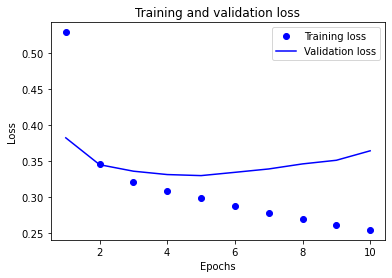

In [38]:

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

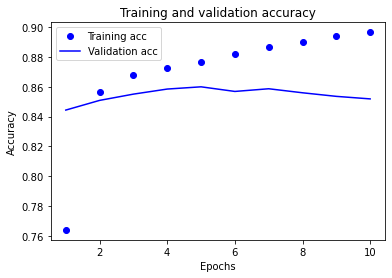

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [40]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf

K_train_data = pd.read_table('~/aiffel/aiffel_nlp_ex/data/naver/ratings_train.txt')
K_test_data = pd.read_table('~/aiffel/aiffel_nlp_ex/data/naver/ratings_test.txt')

K_train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [41]:
print('훈련용 리뷰 개수 :',len(train_data))
print('테스트용 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 146182
테스트용 리뷰 개수 : 49157


In [42]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        #temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        #temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    # 사전 word to index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    #텍스트를 사전 인덱스로 바꾸기 
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

In [43]:
# X_train,X_test,y_train,y_test, word_to_index=load_data(train_data, test_data, num_words=10000)
X_train[:4]

[[43, 88, 936, 4, 4, 50, 244, 30, 44, 765],
 [1045, 4, 19, 536, 566, 704, 7, 135, 4, 84, 1656, 64, 942, 1023, 24, 55, 407],
 [34, 221, 2],
 [8427, 173, 3942, 4, 4, 314, 109, 6, 27, 8, 4, 4, 71, 3496]]

In [44]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [45]:
#텍스트 데이터를 숫자로 바꾸기
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

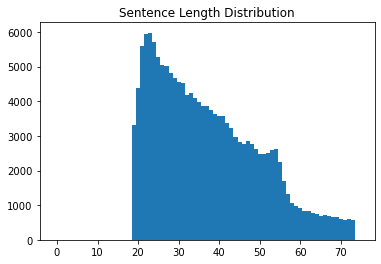

In [46]:
max_len = 75
min_len = 20

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [47]:
# total_data_text = list(X_train) + list(X_test)
# # 텍스트데이터 문장길이의 리스트를 생성한 후
# num_tokens = [len(tokens) for tokens in total_data_text]
# num_tokens = np.array(num_tokens)
# # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
# print('문장길이 평균 : ', np.mean(num_tokens))
# print('문장길이 최대 : ', np.max(num_tokens))
# print('문장길이 표준편차 : ', np.std(num_tokens))

In [48]:
# print('리뷰의 최대 길이 :', np.max(num_tokens))
# print('리뷰의 평균 길이 :', np.mean(num_tokens))
# plt.hist([len(s) for s in X_train], bins=50)
# plt.xlabel('length of samples')
# plt.ylabel('number of samples')
# plt.show()

In [49]:
# # 최대 길이를 41로 지정하면 93%이상을 포함한다.
# max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
# max_len = int(max_tokens)
# print('pad_sequences maxlen : ', max_len)
# print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train,
                       maxlen = max_len,
                       value=word_to_index['<PAD>'],
                       padding='pre')
X_test = pad_sequences(X_test,
                      maxlen = max_len,
                      value=word_to_index['<PAD>'],
                      padding='pre')

In [51]:
print(X_train.shape)
print(X_test.shape)

(146182, 75)
(49157, 75)


In [52]:
#RNN
vocab_size = 10000
word_vector_dim = 16

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 64로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu')) # 안해도 됨
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [53]:
# validation set 29300건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]


print(X_val.shape)
print(y_val.shape)

print(partial_X_train.shape)
print(partial_y_train.shape)

(10000, 75)
(10000,)
(136182, 75)
(136182,)


In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [55]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512, # 512, 100 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
266/266 [==============================] - 3s 8ms/step - loss: 0.6054 - accuracy: 0.6786 - val_loss: 0.3581 - val_accuracy: 0.8471
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3423 - accuracy: 0.8576 - val_loss: 0.3427 - val_accuracy: 0.8532
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3141 - accuracy: 0.8710 - val_loss: 0.3435 - val_accuracy: 0.8509
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3055 - accuracy: 0.8743 - val_loss: 0.3436 - val_accuracy: 0.8532
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2969 - accuracy: 0.8780 - val_loss: 0.3479 - val_accuracy: 0.8533
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2905 - accuracy: 0.8818 - val_loss: 0.3451 - val_accuracy: 0.8534
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2811 - accuracy: 0.8856 - val_loss: 0.3439 - val_accuracy: 0.8530
Epoch 

In [56]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3571 - accuracy: 0.8486
[0.3570994734764099, 0.8485668301582336]


In [57]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


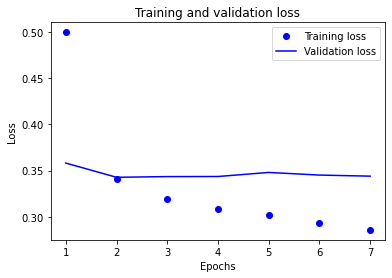

In [58]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

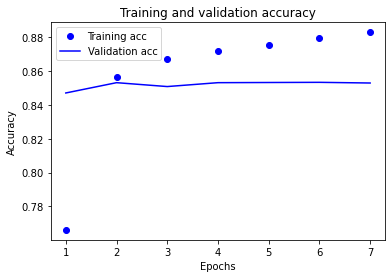

In [59]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 회고

1.  sp.tokenizer와 형태소 분석기의 성능이 별로 큰 차이가 안나는거 같다. 
최대 길이 75, 최소길이 20으로 성능을 비교해봤다. 
sp. tokenizer 는 0.8454
형태소 분석기는 0.8486
2. sp.tokenizer는 패딩을 토크나이저 안에서 처리해줘서 그 안에서 패딩할때 최대길이에 맞춰서 패딩하라는 조건이 필요하다. 